<a href="https://colab.research.google.com/github/LorenzoCapra/Aerial-Images-Segmentation/blob/main/Aerial_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AERIAL SATELLITE IMAGERY SEGMENTATION**

Dataset downloaded from Kaggle:
https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

It contains aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

1.   Building: #3C1098
2.   Land (unpaved area): #8429F6
3.   Road: #6EC1E4
4.   Vegetation: #FEDD3A
5.   Water: #E2A929
6.   Unlabeled: #9B9B9B

A U-Net Convolutional Neural Network architecture is selected for semantic segmentation.
This file contains both the data pre-processing and the training of the model. GPU is advised, as the training may take hours exploiting just CPU capabilities. 
Main issues regard memory crashing on colab when using GPU. In this case you might need to switch to a PRO account or use other services like AWS or Lambda GPU Cloud. 

An intensive explanation and inspiration for this code can be found at: https://www.youtube.com/watch?v=jvZm8REF2KY&t=1313s

In [1]:
# Install a few dependencies that might not be already available on colab
!pip install patchify
!pip install segmentation_models

In [2]:
"""
First import all the dependencies:
"""
import os
import cv2
import numpy as np
import random
import scipy
from tkinter import Tcl
from tqdm import tqdm
import gc

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from sklearn.preprocessing import MinMaxScaler

Segmentation Models: using `keras` framework.


In [3]:
# Define the scaler to rescale the values between 0 and 1
scaler = MinMaxScaler()

# Define the root directory which containd the images and masks
root_directory = 'drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Semantic segmentation dataset/'

'''Using patchify to get all the images of the same shape and remove as little data as possible:
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256
'''
# Define the patch size
patch_size = 256

# Read images from respective 'images' subdirectory.
# As all images are of different size we have 2 options, either resize or crop.
# But some images are too large and some too small. Resizing will change the size of real objects.
# Therefore, we will crop them to a nearest size divisible by 256 and then
# divide all images into patches of 256x256x3.

image_dataset = []
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    # print(path)

    dirname = path.split(os.path.sep)[-1]

    if dirname == 'images':  # Find all 'images' directories
        images = os.listdir(path)  # List of all image names in this subdirectory
        images = Tcl().call('lsort', '-dict', images)

        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):  # Only read jpg images...

                image = cv2.imread(path + "/" + image_name, 1)  # Read each image as BGR
                SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
                image = np.array(image)

                # Extract patches from each image
                # print("Now patchifying image:", path + "/" + image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3),
                                       step=patch_size)  # Step=256 for 256 patches means no overlapping pixels

                for h in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[h, j, :, :]

                        # Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(
                            single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        single_patch_img = single_patch_img[0]  # Drop the extra unnecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

    # Now do the same as above for masks
    # For this specific dataset we could have added masks to the above code as masks have extension png
    elif dirname == 'masks':# Find all 'images' directories
        masks = os.listdir(path)  # List of all image names in this subdirectory
        masks = Tcl().call('lsort', '-dict', masks)

        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):  # Only read png images... (masks in this dataset)

                # Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.imread(path + "/" + mask_name, 1)  
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
                mask = np.array(mask)

                # Extract patches from each image
                # print("Now patchifying mask:", path + "/" + mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3),
                                        step=patch_size)  # Step=256 for 256 patches means no overlap

                for h in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[h, j, :, :]
                        # No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0]  # Drop the extra unnecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

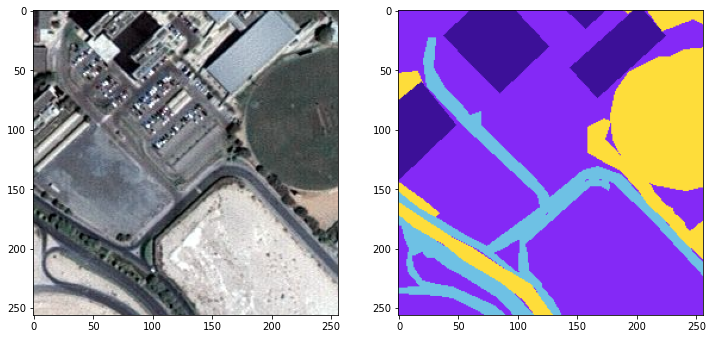

In [ ]:
# Sanity check, view few mages
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [4]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152


# Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a = int('3C', 16)  # 3C with base 16. Should return 60.
print(a)

"""

# Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i + 2], 16) for i in (0, 2, 4)))  # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i + 2], 16) for i in (0, 2, 4)))  # 132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i + 2], 16) for i in (0, 2, 4)))  # 110, 193, 228

Vegetation = 'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i + 2], 16) for i in (0, 2, 4)))  # 254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i + 2], 16) for i in (0, 2, 4)))  # 226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

label = single_patch_mask


# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Supply our label masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg


labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


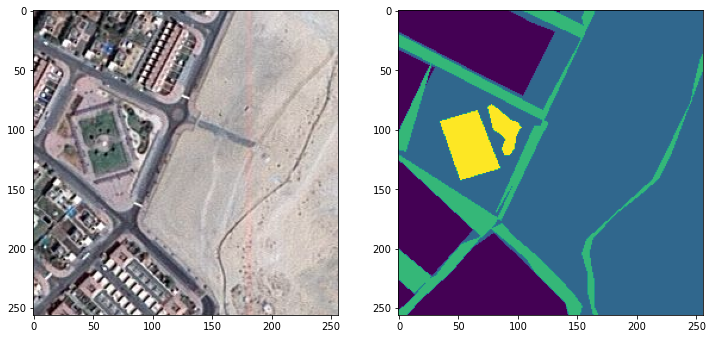

In [ ]:
# Another Sanity check, view few mages
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:, :, 0])
plt.show()

In [5]:
# One hot encoding the labels
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

# Split the dataset into training and testing:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)  

# Define input dimensions for the first NN layer
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [6]:
# Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Set class weights for dice_loss
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [7]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


#################################################################################################################################

# U-Net Model:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
# Define the metric to evaluate the model performance
metrics = ['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Train the model:
history1 = model.fit(X_train, y_train,
                     batch_size=16,
                     verbose=1,
                     epochs=50,
                     validation_data=(X_test, y_test),
                     shuffle=False)

In [ ]:
# Save the model 
model.save('drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Model')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Model/assets


In [ ]:
# Plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [8]:
# Load the saved model:
model = load_model('drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Model', compile=False)

In [9]:
# IOU
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built in keras function for IoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5545013


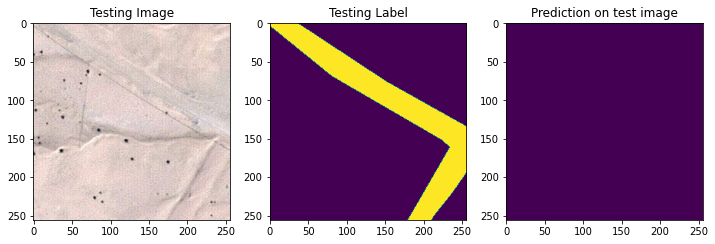

In [ ]:
# Predict on a few images
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [10]:
# Now we want to blend the 256x256 patches to recover the size of original images

"""
Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.
The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed. 
# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE
"""

PLOT_PROGRESS = True

def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1) 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
        
    return prd

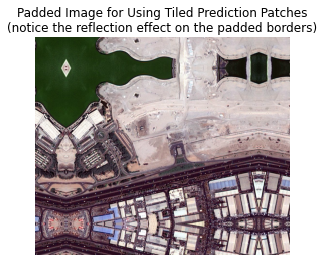

  0%|          | 0/8 [00:00<?, ?it/s]

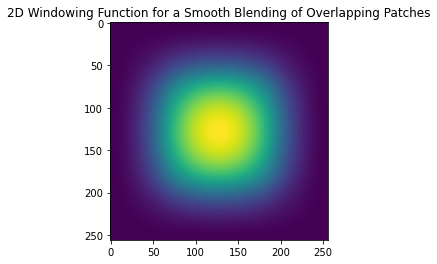

 12%|█▎        | 1/8 [00:04<00:30,  4.35s/it]

In [ ]:
# Load one of the images in the dataset to test smooth blending
img = cv2.imread("drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg", 1)
original_mask = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Aerial Images Segmentation/Semantic segmentation dataset/Tile 1/masks/image_part_008.png", 1)
original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)

# Predict patch by patch without smooth blending
SIZE_X = (img.shape[1]//patch_size)*patch_size # Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size # Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
large_img = np.array(large_img)     


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')


# Predict using smooth blending
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, 
# called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv)))
)


final_prediction = np.argmax(predictions_smooth, axis=2)

In [ ]:
# Convert labeled images back to original RGB colored masks. 

def label_to_rgb(predicted_image):
    
    Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152
    
    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246
    
    Road = '#6EC1E4'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    
    Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58
    
    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41
    
    Unlabeled = '#9B9B9B'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land
    segmented_img[(predicted_image == 2)] = Road
    segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water
    segmented_img[(predicted_image == 5)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)

    return(segmented_img)

In [ ]:
# Plot and save results
prediction_with_smooth_blending=label_to_rgb(final_prediction)
prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()